In [1]:
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt('data/run_001.csv',delimiter=',')

num_data_points = data.shape[0]
num_states = 3

time = np.zeros([num_data_points,])
steering_angle = np.zeros([num_data_points,])
pedal_speed = np.zeros([num_data_points,])
estimated_xpos = np.zeros([num_data_points,])
estimated_ypos = np.zeros([num_data_points,])

time = data[:,0]
steering_angle = data[:,1]
pedal_speed = data[:,2]
estimated_xpos = data[:,3]
estimated_ypos = data[:,4]
true_xpos = data[-1,5]
true_ypos = data[-1,6]

r = 0.425 #Not considering uncertainties
B = 0.8


x_noise = 1 #Assumption
y_noise = 1

In [3]:
def measurement_availability(timestep): 
    return not (np.isnan(data[timestep,3]) and np.isnan(data[timestep,4]))

In [4]:
theta_pred = np.zeros((num_data_points,))
x_pred = np.zeros((num_data_points,))
y_pred = np.zeros((num_data_points,))

theta_pred[0] = np.pi/4
x_pred[0] = estimated_xpos[0] - 0.19 #Offset value x-measurement
y_pred[0] = estimated_ypos[0] - 0.4 #Offset value y-measurement
Pm = np.eye(num_states)

In [5]:
A = np.eye(num_states)
L = np.eye(num_states)
M = np.eye(2)

def H_matrix(theta): 
    H = np.array(([-0.5 * B * np.sin(theta), 1, 0], [0.5 * B * np.cos(theta), 0, 1]))
    return H 

#sigma_vv = np.array(([0.01, 0, 0],[0, 0.4, 0], [0, 0, 0.4])) #Testing different process noises 
sigma_vv = np.zeros((num_states,num_states)) #Assumption no process noise
sigma_ww = np.array(([1.09, 0],[0, 2.98]))

x_noise = 0.1 #Assumption
y_noise = 0.1

In [6]:
def prediction_step(theta, x, y, omega, gamma, current_time, previous_time):
    v = 5 * r * omega * (current_time - previous_time)
    theta_new = theta + v * np.tan(gamma) / B
    x_new = x + v * np.cos(theta)
    y_new = y + v * np.sin(theta)
    return np.array(([theta_new, x_new, y_new]))

In [7]:
def measurement_eq(theta, x, y):
    x_meas = x + 0.5 * B * np.cos(theta) + x_noise - 0.19
    y_meas = y + 0.5 * B * np.sin(theta) + y_noise - 0.4
    return np.array(([x_meas, y_meas])).reshape((2,1))

In [8]:
for i in range(1,num_data_points):
    theta = theta_pred[i-1]
    x = x_pred[i-1]
    y = y_pred[i-1]
    omega = pedal_speed[i-1]
    gamma = steering_angle[i-1]
    
    if not measurement_availability(i): #No measurement available --> naive update 
        
        theta_pred[i], x_pred[i],y_pred[i] = prediction_step(theta,x,y,omega,gamma,time[i],time[i-1])
        
    else: #Measurement available --> update via EKF
    
        thetahatp, xhatp, yhatp = prediction_step(theta,x,y,omega,gamma,time[i],time[i-1])
        
        xhatp = np.array((thetahatp, xhatp, yhatp)).reshape((3,1))
        Pp = A @ Pm @ A.T + L @ sigma_vv @ L.T
        
        pred_meas = measurement_eq(xhatp[0], xhatp[1], xhatp[2])
        true_meas = np.array(([data[i,3], data[i,4]])).reshape((2,1))
        
        H = H_matrix(thetahatp)
        
        K = Pp @ H.T @ sp.linalg.inv(H @ Pp @ H.T + M @ sigma_ww @ M.T)
        xhatm = xhatp + K @ (true_meas - pred_meas)
        Pm = (np.eye(num_states) - K @ H) @ Pp
        
        theta_pred[i] = xhatm[0][0]
        x_pred[i] = xhatm[1]
        y_pred[i] = xhatm[2]

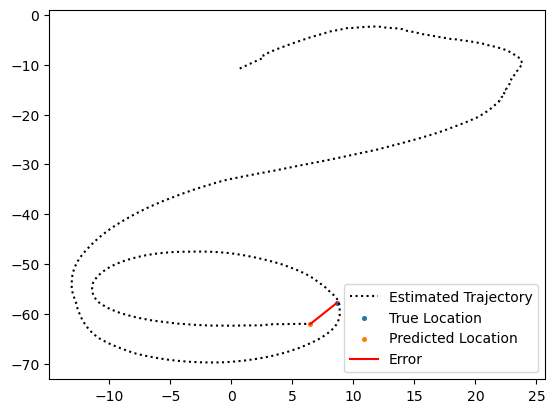

In [9]:
plt.plot(x_pred,y_pred,ls=':', label='Estimated Trajectory',c='k')
plt.scatter(true_xpos,true_ypos,label='True Location',s=7)
plt.scatter(x_pred[-1],y_pred[-1],label='Predicted Location',s=7)
plt.plot([true_xpos, x_pred[-1]], [true_ypos, y_pred[-1]],ls='-',c='r',label='Error')
plt.legend()
plt.show()

In [10]:
([true_xpos - x_pred[-1]], [true_ypos - y_pred[-1]]) #Error be

([2.1516592291514893], [4.194849841996778])